<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture1/learning_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning rate

In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

## 準備

In [2]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        # z1 = self.l1(x)
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x


def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数

    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0

        for train_batch, data in enumerate(train_loader):

            X, y = data
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()

            # backward
            loss.backward()
            optimizer.step()

        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()

        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1

        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies

In [3]:
# データロード
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0~16 -> 0~255
images = images.astype(np.uint8)
# 学習データと検証データ作成
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# DatasetとDataLoader作成
transform = transforms.Compose([
    transforms.ToTensor(),# 0~255 -> 0~1
    transforms.Normalize((.5, ), (.5, )) # 0~1 -> -1~1
])

batch_size = 10
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
early_stopping = 5
## Refactoring後の学習ループ
learning_rate = 0.1
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
num_epoch = 100

## Learning rate finder

In [4]:
# optimizerの.param_groupsの中に様々なパラメータが保持されていて，learning rateもここに格納されている
for param_group in opt.param_groups:
    param_group['lr'] *= 1.1

In [5]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[-0.0620, -0.0966, -0.0300,  ...,  0.0856, -0.0465,  0.0072],
           [ 0.0178,  0.0999, -0.0120,  ...,  0.0801, -0.1056,  0.1130],
           [-0.0415, -0.0217,  0.0124,  ..., -0.0265, -0.0388, -0.0811],
           ...,
           [ 0.0043,  0.0562, -0.0306,  ..., -0.0481,  0.0201, -0.0775],
           [-0.0500,  0.0851, -0.0717,  ..., -0.0343, -0.0611,  0.1204],
           [ 0.0314,  0.1200, -0.0741,  ..., -0.0391,  0.0708, -0.0829]],
          requires_grad=True),
   Parameter containing:
   tensor([-0.1168, -0.0199, -0.0368, -0.0719,  0.0874, -0.1205,  0.0351, -0.0923,
            0.0979, -0.0152,  0.0993,  0.0277, -0.0150,  0.0539, -0.0363,  0.0403,
           -0.0993,  0.1211, -0.0224, -0.0109,  0.0796, -0.0809,  0.1185, -0.1143,
           -0.1248,  0.0991, -0.0866, -0.1145,  0.0056, -0.0380],
          requires_grad=True),
   Parameter containing:
   tensor([[ 0.1444,  0.0450,  0.0319, -0.1249,  0.0267, -0.1213, -0.1741, -0.1340,

In [6]:
def lr_finder(model, train_loader, loss_func, lr_multiplier=1.2):

    lr = 1e-8
    max_lr = 10
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    lrs = []

    for train_batch, data in enumerate(train_loader):
        X, y = data

        opt.zero_grad()
        # forward
        preds = model(X)
        loss = loss_func(preds, y)
        losses.append(loss.item())
        lrs.append(lr)

        # backward
        loss.backward()
        opt.step()

        lr *= lr_multiplier

        for param_group in opt.param_groups:
            param_group['lr'] = lr
        if lr > max_lr:
            break

    return lrs, losses

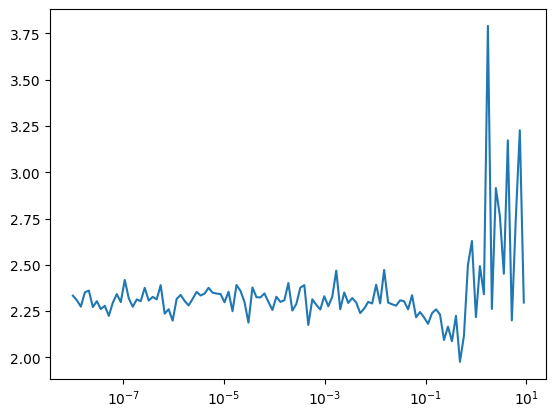

In [7]:
lrs, losses = lr_finder(model, train_loader, F.cross_entropy, lr_multiplier=1.2)
plt.plot(lrs, losses)
plt.xscale('log')

## Learning rate scheduler

In [8]:
# StepLR
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(opt, step_size=30, gamma=0.1)
for param_group in opt.param_groups:
    print(param_group['lr'])
for epoch in range(60):
    scheduler.step()
for param_group in opt.param_groups:
    print(param_group['lr'])

0.1
0.0010000000000000002


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [9]:
# CosineAnnealing
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(opt, T_max=50)
lrs = []
for epoch in range(150):
    lrs.append(opt.param_groups[0]['lr'])
    scheduler.step()

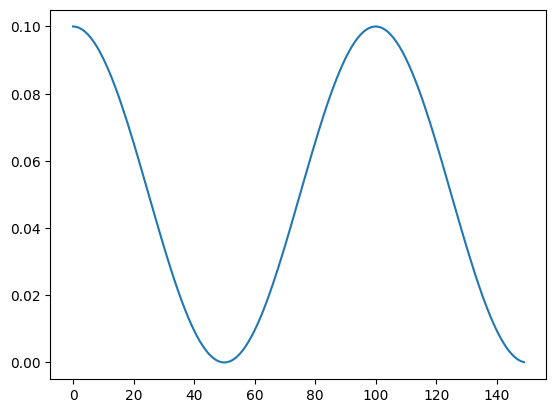

In [10]:
plt.plot(lrs)

In [11]:
# learning rate schedulerを学習ループに組み込む
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None, scheduler=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数

    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0

        for train_batch, data in enumerate(train_loader):

            X, y = data
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()

            # backward
            loss.backward()
            optimizer.step()

        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()

        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1

        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accuracies

In [12]:
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(opt, step_size=30, gamma=0.1)
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, 100, scheduler=scheduler)

epoch: 0: train error: 1.0985165181466274, validation error: 0.38886847181452644, validation accuracy: 0.8916666607062022
epoch: 1: train error: 0.2681087587649624, validation error: 0.19906652025464508, validation accuracy: 0.9361111041572359
epoch: 2: train error: 0.16515930489792177, validation error: 0.15225925030083293, validation accuracy: 0.9499999930461248
epoch: 3: train error: 0.12667580927437586, validation error: 0.1499564583516783, validation accuracy: 0.958333326710595
epoch: 4: train error: 0.10315839709558834, validation error: 0.1354150425047717, validation accuracy: 0.958333326710595
epoch: 5: train error: 0.08911832932305212, validation error: 0.14612515713088214, validation accuracy: 0.9472222146060731
epoch: 6: train error: 0.08102232564043435, validation error: 0.10958358760560966, validation accuracy: 0.9666666620307498
epoch: 7: train error: 0.06611278421931072, validation error: 0.11569272966072378, validation accuracy: 0.9611111051506467
epoch: 8: train error: